## Imports and inital setup

In [81]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import string
import sys

SEED = 42
MAX_SAMPLES = 1500
NUM_CLASSES = 7
NUM_EPOCHS = 10

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/processed/Metadata_processed.csv"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
TARGET_LABEL="dx_binary"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)

### Deleting all previously augmented images in advance

In [82]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/" 

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


### Loading the metadata file

In [83]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0031633.jpg


# Splitting the data in train, validation and test sets

In [84]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata[TARGET_LABEL], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[TARGET_LABEL], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 10)

(2003, 10)

(2003, 10)

# Tackling Class imbalances in the training set

## Setting up the image data generator for training

In [85]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_augment = ImageDataGenerator(
    rotation_range=40,   # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the width by up to 20%
    height_shift_range=0.2, # Randomly shift the height by up to 20%
    shear_range=0.2,     # Apply shear transformations
    zoom_range=0.2,      # Apply zoom transformations
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Create an ImageDataGenerator for validation data (no augmentation)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0 #see above
)


### Helper Function: Load images from directory and return as numpy array

In [86]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size=IMAGE_SIZE):
    # Load the image using PIL
    image = Image.open(image_path)
    
    # Resize the image to the target size
    image = image.resize(target_size)
    
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)
    
    # Perform any additional preprocessing steps here
    # For example, you can normalize pixel values to [0, 1]
    # image_array = image_array / 255.0
    
    return image_array

### Helper Function: Generate hash-string

In [87]:
# Define a function to generate a random string for image ID prefixes
def generate_random_string(length=6):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

## Preparing data for augmentation

In [88]:
# Create separate DataFrames for each class 

class_dataframes = {}
for class_label in train_df[BALANCE_LABEL].unique():
    class_dataframes[class_label] = train_df[train_df[BALANCE_LABEL] == class_label]
    print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")
    #display(class_dataframes[class_label].head())

Class bkl has 660 samples
Class mel has 654 samples
Class nv has 4018 samples
Class akiec has 203 samples
Class bcc has 315 samples
Class df has 77 samples
Class vasc has 82 samples


In [89]:
# Initialize a dictionary to keep track of the number of augmented images per class
class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

# Create a list to store DataFrames for each class
augmented_dataframes = []

# Apply data augmentation for classes with few examples, trim classes with too many examples
for class_label, class_df in class_dataframes.items():
    
    # Describing the overall progress
    print(f"\nChecking class {class_label}...")

    # Check if the class has already reached the maximum number of augmented images // TO BE DELETED
    #if class_augmentation_counts[class_label] >= MAX_SAMPLES:
    #    continue

    # Calculate the number of images needed to reach MAX_SAMPLES for this class
    images_needed = MAX_SAMPLES - class_df.shape[0]
    
    # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
    if images_needed < 0:
        print(f"> Result: Class {class_label} was reduced to {MAX_SAMPLES} samples")
        reduced_df = class_df.sample(n=MAX_SAMPLES, random_state=SEED)
        augmented_dataframes.append(reduced_df)
        continue
    # If images_needed is zero, skip this class
    elif images_needed == 0:
        print(f"> Result: Class {class_label} already has exactly {MAX_SAMPLES} samples")
        augmented_dataframes.append(class_df)
        continue

    # Generate augmented data - this part only runs if images_needed is positive
    print(f"> Result: Class {class_label} needs {images_needed} more images")
    augmented_dataframes.append(class_df)

    while class_augmentation_counts[class_label] <= images_needed:

        # Describing the subprocess progress for each class
        sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
        sys.stdout.flush()

        # Randomly select an image from the class_df
        i = random.randint(0, class_df.shape[0] - 1)
        image_path = class_df.iloc[i]['image_path']

        # Load and preprocess the image
        img = load_and_preprocess_image(image_path)

        # Apply data augmentation via generator
        augmented_img = datagen_augment.random_transform(img)

        # Create a new image ID with prefix
        augmented_image_id = f'aug_{generate_random_string()}' + os.path.basename(image_path)

        # Create a new image path with the augmented image ID as string
        augmented_image_path = FILEPATH_JPGS + augmented_image_id
        
        # Create a new DataFrame for the augmented data for this instance only
        augmented_instance_df = class_df.iloc[i:i+1].copy()
        
        # Reset the index of the new DataFrame
        augmented_instance_df.reset_index(drop=True, inplace=True)

        # Update the "image_id" column with the augmented image ID
        augmented_instance_df.at[0, 'image_id'] = augmented_image_id
        
        # Update the "image_path" column with the augmented image path
        augmented_instance_df.at[0, 'image_path'] = augmented_image_path
        
        # Append the augmented DataFrame for this instance to the list
        augmented_dataframes.append(augmented_instance_df)

        # Save the augmented image to the output folder
        augmented_image_path = os.path.join(FILEPATH_OUTPUT, augmented_image_id)
        plt.imsave(augmented_image_path, augmented_img)

        # Update the counter for the class
        class_augmentation_counts[class_label] += 1

        #if class_augmentation_counts[class_label] > 18:
        #    break

# Combine all augmented DataFrames into a single DataFrame
balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

balanced_train_df.shape



Checking class bkl...
> Result: Class bkl needs 840 more images
Progress: 840/840
Checking class mel...
> Result: Class mel needs 846 more images
Progress: 846/846
Checking class nv...
> Result: Class nv was reduced to 1500 samples

Checking class akiec...
> Result: Class akiec needs 1297 more images
Progress: 1297/1297
Checking class bcc...
> Result: Class bcc needs 1185 more images
Progress: 1185/1185
Checking class df...
> Result: Class df needs 1423 more images
Progress: 1423/1423
Checking class vasc...
> Result: Class vasc needs 1418 more images
Progress: 1418/1418

(10506, 10)

In [90]:
# counting the number of samples per class
balanced_train_df[TARGET_LABEL].value_counts()

dx_binary
not_skin_cancer    6003
skin_cancer        4503
Name: count, dtype: int64

### Helper Function: Checking the image file folder

In [91]:
# Checking what's going on in the fleder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 17030
Files starting with 'aug_': 7015


In [92]:
balanced_train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
4799,HAM_0006560,aug_yiOOTgISIC_0027802.jpg,akiec,histo,50.0,male,face,rosendahl,skin_cancer,./../data/jpgs/aug_yiOOTgISIC_0027802.jpg
9723,HAM_0002914,aug_dPkGx7ISIC_0026092.jpg,vasc,histo,75.0,male,upper extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_dPkGx7ISIC_0026092.jpg
5962,HAM_0005389,aug_JoAxGwISIC_0024372.jpg,akiec,histo,70.0,male,lower extremity,rosendahl,skin_cancer,./../data/jpgs/aug_JoAxGwISIC_0024372.jpg
5658,HAM_0002648,aug_500DcqISIC_0027650.jpg,akiec,histo,40.0,male,neck,rosendahl,skin_cancer,./../data/jpgs/aug_500DcqISIC_0027650.jpg
10459,HAM_0006889,aug_1bNS1MISIC_0031270.jpg,vasc,histo,20.0,male,upper extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_1bNS1MISIC_0031270.jpg
8192,HAM_0003081,aug_U8ngGmISIC_0033847.jpg,df,consensus,45.0,male,abdomen,vidir_modern,not_skin_cancer,./../data/jpgs/aug_U8ngGmISIC_0033847.jpg
10187,HAM_0003480,aug_hONJOYISIC_0033844.jpg,vasc,consensus,70.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_hONJOYISIC_0033844.jpg
3967,HAM_0004802,ISIC_0026551.jpg,nv,histo,45.0,female,back,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0026551.jpg
7081,HAM_0003328,aug_4NrMwSISIC_0031489.jpg,bcc,histo,55.0,female,back,vidir_modern,skin_cancer,./../data/jpgs/aug_4NrMwSISIC_0031489.jpg
8501,HAM_0007410,aug_lDCpDOISIC_0031457.jpg,df,histo,65.0,male,foot,rosendahl,not_skin_cancer,./../data/jpgs/aug_lDCpDOISIC_0031457.jpg


## Plotting the balanced classes

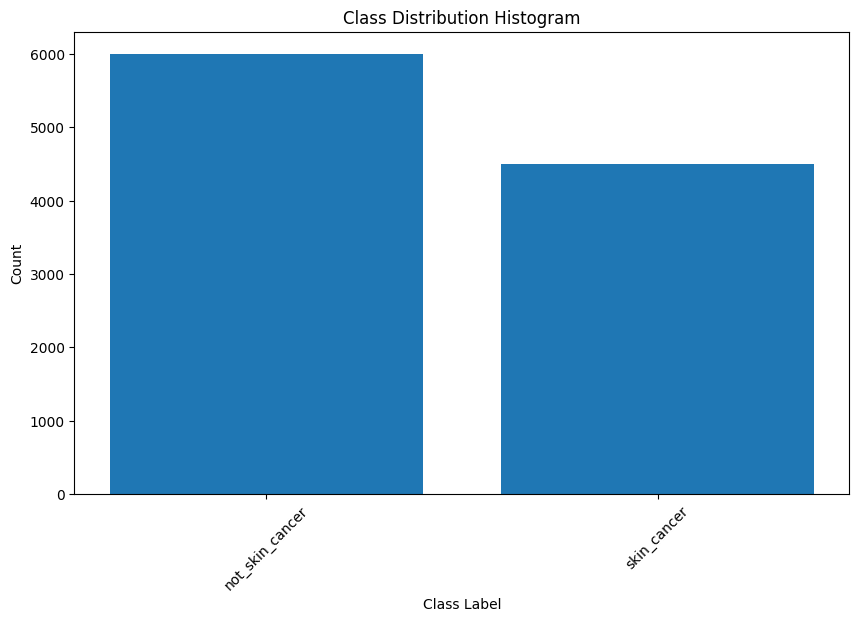

In [93]:
# Count the occurrences of each class in the DataFrame
class_counts = balanced_train_df[TARGET_LABEL].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution Histogram')
plt.xticks(rotation=45)
plt.show()

## Setting upt the image data generator for validation

In [94]:
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    #subset="validation",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

Found 2003 validated image filenames belonging to 2 classes.


## Saving Test, Validation and Training data to csv

In [ ]:
balanced_train_df.to_csv('../data/processed/train_from_Metadata_processed.csv', index=False)
validation_df.to_csv('../data/processed/validation_from_Metadata_processed.csv', index=False)
test_df.to_csv('../data/processed/test_from_Metadata_processed.csv', index=False)